In [86]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [88]:
# CSV yolunu kendine göre güncelle
csv_path = "spam.csv"  # Örn: "spam.csv"

df = pd.read_csv(csv_path , encoding="latin1",)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Beklenen sütunlar:
assert {"v1", "v2"}.issubset(df.columns), "CSV'de 'category' ve 'sentences' sütunları olmalı!"

# Boş değerleri temizle
df = df.dropna(subset=["v1", "v2"]).reset_index(drop=True)

print(df.head())
print(df["v1"].value_counts())

# temizlenmiş dataframe'i kaydet
df.to_csv("spam_clean.csv", index=False, encoding="utf-8")

     v1                                                 v2
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
v1
ham     4825
spam     747
Name: count, dtype: int64


In [90]:
#Cleaning Processes
import pandas as pd
import re

# --- 0) Veriyi yükle (gerekirse kendi yolunu/encoding'ini değiştir) ---
df = pd.read_csv("spam.csv", encoding="latin1")
# Unnamed kolonları at
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# --- 1) Metin ve kategori kolonlarını otomatik bul ---
TEXT_CANDIDATES = ["message","messages","text","sms","sentence","sentences","v2","body","content"]
CAT_CANDIDATES  = ["category","label","class","target","v1","type"]

def pick_col(cands, cols):
    for c in cands:
        if c in cols:
            return c
    # basit fallback: ilk string tipi kolonu al
    for c in cols:
        if pd.api.types.is_string_dtype(df[c]):
            return c
    raise ValueError("Metin kolonu bulunamadı. Lütfen text kolonu adını kontrol et.")

text_col = pick_col(TEXT_CANDIDATES, list(df.columns))
# Kategori kolonu şart değil; sadece dursun
cat_col  = None
for c in CAT_CANDIDATES:
    if c in df.columns:
        cat_col = c
        break

print(f"📝 Metin kolonu: {text_col}" + (f" | 🏷️ Kategori kolonu: {cat_col}" if cat_col else ""))

# --- 2) Temizleme fonksiyonu ---
URL_RE    = re.compile(r"(https?://\S+|www\.\S+)", re.IGNORECASE)
EMAIL_RE  = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")
PHONE_RE  = re.compile(r"\b(?:\+?\d{1,3}[\s-]?)?(?:\(?\d{3}\)?[\s-]?)?\d{3}[\s-]?\d{4}\b")
WS_RE     = re.compile(r"\s+")
# Türkçe karakterleri koruyup sembolleri silen desen:
PUNCT_RE  = re.compile(r"[^0-9a-zA-ZçğıöşüÇĞİÖŞÜ\s]")

def clean_text(s: str, keep_digits=True):
    if pd.isna(s):
        return ""
    s = str(s).strip().lower()
    s = URL_RE.sub(" ", s)
    s = EMAIL_RE.sub(" ", s)
    s = PHONE_RE.sub(" ", s)
    # sembolleri sil
    if keep_digits:
        s = PUNCT_RE.sub(" ", s)   # sayıları korur
    else:
        # sayıları da kaldırmak istersen:
        s = re.sub(r"[^a-zA-ZçğıöşüÇĞİÖŞÜ\s]", " ", s)
    # tek boşluğa indir
    s = WS_RE.sub(" ", s).strip()
    return s

# --- 3) Uygula ---
df["v3_cleaned"] = df[text_col].apply(clean_text)

# --- 4) Hızlı kontrol ---
print(df[[text_col, "v3_cleaned"]].head())

# --- 5) Kaydetmek istersen ---
df.to_csv("spam_clean.csv", index=False, encoding="latin1")
print("✅ Temizlenmiş veri 'spam_clean.csv' olarak kaydedildi.")

📝 Metin kolonu: v2 | 🏷️ Kategori kolonu: v1
                                                  v2  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                          v3_cleaned  
0  go until jurong point crazy available only in ...  
1                            ok lar joking wif u oni  
2  free entry in 2 a wkly comp to win fa cup fina...  
3        u dun say so early hor u c already then say  
4  nah i don t think he goes to usf he lives arou...  
✅ Temizlenmiş veri 'spam_clean.csv' olarak kaydedildi.


In [92]:
import nltk
from nltk.corpus import stopwords

# İlk defa indirmen gerekirse:
# nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

# Yeni kolon ekleyelim
df["key_column"] = df["v3_cleaned"].apply(remove_stopwords)
df.to_csv("spam_clean.csv", index=False, encoding="latin1")
print(df[["v3_cleaned", "key_column"]].head())

                                          v3_cleaned  \
0  go until jurong point crazy available only in ...   
1                            ok lar joking wif u oni   
2  free entry in 2 a wkly comp to win fa cup fina...   
3        u dun say so early hor u c already then say   
4  nah i don t think he goes to usf he lives arou...   

                                          key_column  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry 2 wkly comp win fa cup final tkts 2...  
3                u dun say early hor u c already say  
4             nah think goes usf lives around though  


📝 text: key_column | 🏷️ label: v1
✅ Accuracy: 0.9686
              precision    recall  f1-score   support

         ham       0.99      0.97      0.98       966
        spam       0.84      0.95      0.89       149

    accuracy                           0.97      1115
   macro avg       0.92      0.96      0.94      1115
weighted avg       0.97      0.97      0.97      1115

📊 Confusion Matrix (sayısal):
 [[939  27]
 [  8 141]]


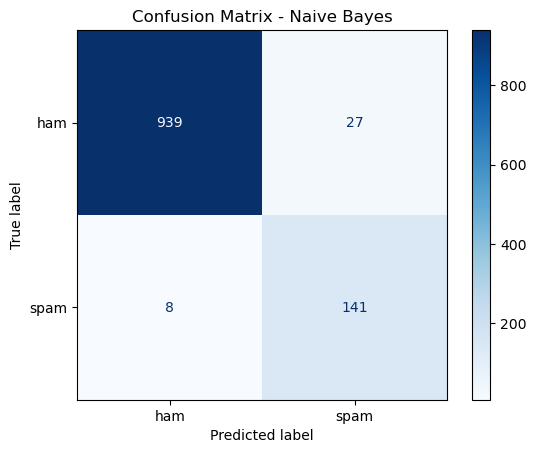

💾 Kaydedildi: tfidf_vectorizer.joblib, nb_spam_model.joblib


In [104]:
from sklearn.utils.class_weight import compute_sample_weight
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# 0) Veri: mevcut df'in varsa bu satırı atlayabilirsin.
df = pd.read_csv("spam_clean.csv", encoding="latin1")

# 1) Metin ve etiket kolonlarını otomatik seç
TEXT_CANDS = ["key_column"]   # senin metin kolonun
LABEL_CANDS = ["v1"]          # senin label kolonun

text_col = next(c for c in TEXT_CANDS if c in df.columns)
y_col    = next(c for c in LABEL_CANDS if c in df.columns)

print(f"📝 text: {text_col} | 🏷️ label: {y_col}")

# Etiketi sayısala çevir (ham=0, spam=1)
if df[y_col].dtype == "O":
    df[y_col] = df[y_col].str.strip().str.lower().map({"ham":0, "spam":1}).fillna(df[y_col])

X_text = df[text_col].astype(str)
y = df[y_col].astype(int)

# 2) Train/Test split
X_tr, X_te, y_tr, y_te = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

# 3) TF-IDF
tfidf = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    min_df=2, max_df=0.9,
    max_features=50000
)

Xtr = tfidf.fit_transform(X_tr)
Xte = tfidf.transform(X_te)

# 4) Model
# örnek ağırlıkları hesapla
sample_w = compute_sample_weight(class_weight="balanced", y=y_tr)
clf = MultinomialNB()
clf.fit(Xtr, y_tr, sample_weight=sample_w)

# 5) Değerlendirme
pred = clf.predict(Xte)
print("✅ Accuracy:", round(accuracy_score(y_te, pred), 4))
print(classification_report(y_te, pred, target_names=["ham","spam"]))

# 6) Confusion Matrix
cm = confusion_matrix(y_te, pred)
print("📊 Confusion Matrix (sayısal):\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham","spam"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

# 7) Kaydet
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
joblib.dump(clf, "nb_spam_model.joblib")
print("💾 Kaydedildi: tfidf_vectorizer.joblib, nb_spam_model.joblib")

# 8) Örnek kullanım
# new_texts = ["You won a lottery! claim now", "Are we meeting at 6?"]
# X_new = tfidf.transform(new_texts)
# print(clf.predict(X_new))  # 0=ham, 1=spam